#Portfolio Optimization

##Data Processing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as sci_opt
import yfinance as yf

from pprint import pprint
from sklearn.preprocessing import StandardScaler

In [11]:
# User Input
# Define assets
assets = ['AAPL', 'DIS', 'GC=F', 'META']
number_of_stocks = len(assets)

# Define start date
start_date = '2015-01-01'

In [12]:
# Fetch data
data = yf.download(assets, start_date)['Adj Close']
data = round(data,3)

# Print head of data
print(data.head())
print(type(data))

[*********************100%***********************]  4 of 4 completed
              AAPL     DIS    GC=F   META
Date                                     
2015-01-02  24.566  87.376  1186.0  78.45
2015-01-05  23.874  86.099  1203.9  77.19
2015-01-06  23.876  85.643  1219.3  76.15
2015-01-07  24.211  86.519  1210.6  76.15
2015-01-08  25.141  87.414  1208.4  78.18
<class 'pandas.core.frame.DataFrame'>


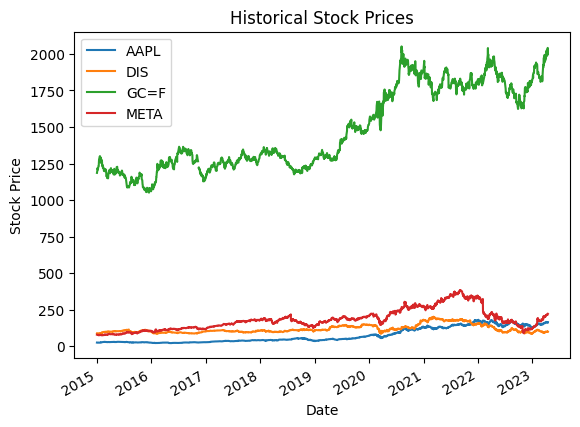

In [13]:
# Plot historical stock prices
%matplotlib inline

(data[assets]).plot()

plt.title('Historical Stock Prices')
plt.xlabel('Date')
plt.ylabel('Stock Price')

plt.show()

In [14]:
# Calculate Sharpe ratio
def get_sharp_ratio(data, weights):
  # Calculate the Log of returns.
  log_return = np.log(data / data.shift(1))

  # Calculate the Annualized Expected Returns
  NUM_OF_DAYS = 252
  exp_return = np.dot(weights, log_return.mean() * NUM_OF_DAYS)

  # Calculate the Annualized Expected Volatility
  exp_vol = np.sqrt(np.dot(weights.T, np.dot(log_return.cov() * 252, weights)))

  # Calculate the Sharpe Ratio
  sharpe_ratio = exp_return / exp_vol

  return (exp_return, exp_vol, sharpe_ratio)

In [6]:
# Initialize Random Weights for Monte Carlo Simulations
def get_random_weights(number_of_stocks):
  # Generate Random Weights.
  random_weights = np.array(np.random.random(number_of_stocks))

  # Make sure weights sum up to 1
  init_weights = random_weights / np.sum(random_weights)
  return init_weights

##Monte Carlo Simulations

In [7]:
# Get Monte Carlo Simulations for a given num of iterations
def monte_carlo_simulations(data, num_of_iter):
  # Initialization
  all_weights = np.zeros((num_of_iter, number_of_stocks))
  return_arr = np.zeros(num_of_iter)
  vol_arr = np.zeros(num_of_iter)
  sharpe_arr = np.zeros(num_of_iter)

  # Simulations
  for i in range(num_of_iter):
    weights = get_random_weights(number_of_stocks)
    all_weights[i, :] = weights

    exp_return, exp_vol, sharpe_ratio = get_sharp_ratio(data, weights)
    return_arr[i] = exp_return
    vol_arr[i] = exp_vol
    sharpe_arr[i] = sharpe_ratio
  

  simulations_data = [return_arr, vol_arr, sharpe_arr, all_weights]
  simulations_df = pd.DataFrame(data=simulations_data).T

  simulations_df.columns = [
    'Returns',
    'Volatility',
    'Sharpe Ratio',
    'Portfolio Weights'
  ]

  simulations_df = simulations_df.infer_objects()
  return simulations_df

In [8]:
# Run Monte Carlo Simulations on our assets to find max return
np.random.seed(42)

simulations_df = monte_carlo_simulations(data, 1000)
simulations_df.head()

,Returns,Volatility,Sharpe Ratio,Portfolio Weights
0,0.087701,0.190033,0.461505,"[0.1410215567872302, 0.3579622176722185, 0.275..."
1,0.126026,0.309863,0.406717,"[0.12620080734580005, 0.12618129700478345, 0.0..."
2,0.122055,0.267131,0.456913,"[0.26139050028350513, 0.3079002216404562, 0.00..."
3,0.166382,0.232326,0.716156,"[0.5903801501374071, 0.15059391470113248, 0.12..."
4,0.095456,0.186407,0.512083,"[0.1960105449641472, 0.33807860847040766, 0.27..."


In [9]:
# Get maximum Sharpe Ratio and Minimum Volatility in our simulation
def get_max_sharpe_ratio(df):
  return df.loc[df['Sharpe Ratio'].idxmax()]

def get_min_volatility(df):
  return df.loc[df['Volatility'].idxmin()]

print(get_max_sharpe_ratio(simulations_df))
print(get_min_volatility(simulations_df))

Returns                                                       0.137548
Volatility                                                    0.154065
Sharpe Ratio                                                  0.892791
Portfolio Weights    [0.4087945008923314, 0.0038573348687276202, 0....
Name: 475, dtype: object
Returns                                                       0.075286
Volatility                                                    0.130866
Sharpe Ratio                                                  0.575294
Portfolio Weights    [0.07641406836395452, 0.2075987639640013, 0.64...
Name: 283, dtype: object


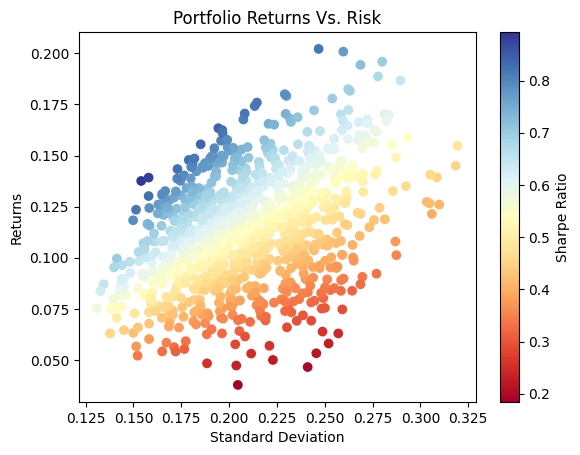

In [15]:
# Plot Monte Carlo Simulations, colored by Sharpe Ratio
%matplotlib inline

plt.scatter(
    y=simulations_df['Returns'],
    x=simulations_df['Volatility'],
    c=simulations_df['Sharpe Ratio'],
    cmap='RdYlBu'
)

plt.title('Portfolio Returns Vs. Risk')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Standard Deviation')
plt.ylabel('Returns')

plt.show()

## Maximize Sharpe Ratio and Minimize Volatility

In [18]:
# Calculate Bounds and Constraints
constraints = ({'type' : 'eq', 'fun': lambda x: np.sum(x) -1})
bounds = tuple((0,1) for x in range(number_of_stocks))
initializer = number_of_stocks * [1./number_of_stocks,]

print (initializer)
print (bounds)

[0.25, 0.25, 0.25, 0.25]
((0, 1), (0, 1), (0, 1), (0, 1))


In [19]:
# Get Maximized Sharpe Ratio 
def maximize_sharpe(weights):  
    return -get_sharp_ratio(data, weights)[2]

# Get Minimized Volatility
def minimize_volatility(weights):  
    return get_sharp_ratio(data, weights)[1]

In [21]:
# Calculate Expected Return when Maximized Sharpe Ratio
import scipy.optimize as optimize

optimal_sharpe = optimize.minimize(maximize_sharpe,
                                 initializer,
                                 method = 'SLSQP',
                                 bounds = bounds,
                                 constraints = constraints)
print("Maximize Sharpe Ratio:", get_sharp_ratio(data, optimal_sharpe.x)[2])
print("Expected Return when Maximized Sharpe Ratio:", get_sharp_ratio(data, optimal_sharpe.x)[0])
print("Optimal Weight when Maximized Sharpe Ratio:", optimal_sharpe.x)
print("Comapre to Maximium Sharpe Ratio from Monte Carlo Simulation:", get_max_sharpe_ratio(simulations_df)["Sharpe Ratio"])

Maximize Sharpe Ratio 0.9037600856437382
Expected Return when Maximized Sharpe Ratio 0.14491152818822312
Optimal Weight when Maximized Sharpe Ratio: [4.61982790e-01 8.76577456e-17 5.38017210e-01 0.00000000e+00]
Maximized Sharpe Ratio from Monte Carlo Simulation: 0.8927907553523122


In [22]:
# Calculate Expected Return when Minized Volatility
optimal_volatility = optimize.minimize(minimize_volatility,
                                 initializer,
                                 method = 'SLSQP',
                                 bounds = bounds,
                                 constraints = constraints)

print("Minimized Volatility:", get_sharp_ratio(data, optimal_volatility.x)[1])
print("Expected Return when Minimized Volatility:", get_sharp_ratio(data, optimal_volatility.x)[0])
print("Optimal Weight when Minimized Volatility:", optimal_volatility.x)
print("Compare to Minimum Volatility from Monte Carlo Simulation:", get_min_volatility(simulations_df)["Volatility"])

Minimized Volatility: 0.1273084737726153
Expected Return when Minimized Volatility: 0.07855373627403436
Optimal Weight when Minimized Volatility: [0.09619369 0.14699807 0.73507841 0.02172982]
Compare to Minimum Volatility from Monte Carlo Simulation: 0.13086564814535542


In [23]:
def get_percentage_increase(cur_rate):
  BASELINE_RATE = 0.0417 # 3 Month Treasury Bill Rate, long term average
  return round((cur_rate - BASELINE_RATE) / BASELINE_RATE, 3) * 100

In [24]:
# Compare our expected return rate with baseline return rate (risk-free rate of return)
print("Expected Return rate of Maximum Sharpe Ratio compared to baseline rate", get_percentage_increase(0.14312363124508606), "%")
print("Expected Return rate of Minimum Volatility compared to baseline rate", get_percentage_increase(0.07555356325785158), "%")

Expected Return rate of Maximum Sharpe Ratio compared to baseline rate 243.2 %
Expected Return rate of Minimum Volatility compared to baseline rate 81.2 %


#Conclusion

Compare to the Risk-Free Rate of Return, our expected return rates after optimization are significantly higher.

*   Expected Return rate of Maximum Sharpe Ratio -- 14.4% (increased 243.2%)
*   Expected Return rate of Minimum Volatility -- 7.85% (increased 81.2%)



Thank you for reading, created by Zhenxin ✅